# Assignment 2: Practical Deep Learning for Language Processing (DS405B)
submitted by Tim-Moritz Bündert (ID: 5635975) on December 20, 2021

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set data directory
data_dir = "/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_2/"

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torchtext.vocab import vocab
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Emotion Classification from Text

## Dataset and vocabulary

### Load data and create training and validation datasets

In [8]:
data = pd.read_csv(data_dir+'training.csv')  
n_classes = len(data['sentiment'].unique())

print(f"Shape of dataset: {data.shape}")
print(f"Labels of training dataset: {data['sentiment'].unique()}")
display(data.head())

Shape of dataset: (24837, 2)
Labels of training dataset: ['sadness' 'neutral' 'worry' 'happiness']


,sentiment,content
0,sadness,Layin n bed with a headache ughhhh...waitin o...
1,sadness,Funeral ceremony...gloomy friday...
2,neutral,@dannycastillo We want to trade with someone w...
3,worry,Re-pinging @ghostridah14: why didn't you go to...
4,sadness,"I should be sleep, but im not! thinking about ..."


In [9]:
np.random.seed(42)

# split dataset into training (90%) and validation (10%) set
train_dataset = data.sample(int(np.ceil(0.9*data.shape[0])), replace = False)
val_dataset = data.drop(train_dataset.index)

print(f"Shape of training dataset: {train_dataset.shape}")
print(f"Shape of validation dataset: {val_dataset.shape}")

Shape of training dataset: (22354, 2)
Shape of validation dataset: (2483, 2)


### Implement a custom PyTorch `Dataset` class

In [10]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
      self.data = data

    def __len__(self):
      return(self.data.shape[0])

    def __getitem__(self, idx):
      return (self.data.iloc[idx,0], self.data.iloc[idx,1])

train_dataset_PT = Custom_Dataset(train_dataset)
val_dataset_PT = Custom_Dataset(val_dataset)

### Load the 100-dimensional `GloVe`embeddings pre-trained on the Twitter dataset

In [ ]:
glove = torchtext.vocab.GloVe(name='twitter.27B', dim=100, cache=data_dir)
print('Loaded {} words'.format(len(glove.itos)))

Loaded 1193514 words


### Build vocabulary

In [ ]:
def tokenize(data_iter):
  for label_class, text in data_iter:
    tokenized_text = tokenizer(text)
    text_reduced = [token for token in tokenized_text if token in glove_words] # remove tokens which are not part of pre-trained GloVe vocab
    yield text_reduced

In [ ]:
tokenizer = get_tokenizer('basic_english')
glove_words = list(glove.stoi)

In [ ]:
vocab = torchtext.vocab.build_vocab_from_iterator(tokenize(train_dataset_PT), specials=["<unk>"], min_freq=10) # build vocab based on training dataset
pad_index = 0
vocab.insert_token("<pad>", 0) # token for padding
vocab.set_default_index(vocab["<unk>"]) # token for unknown tokens

# making sure that the vocab works
print(vocab(['here', 'is']))
print(len(vocab))

[104, 15]
2177


In [ ]:
# create embedding matrix corresponding to the constructed vocab
embedding_matrix = torch.zeros((len(vocab), 100))

for i, word in enumerate(vocab.get_itos()):
  try:
    embedding_matrix[i,] = glove.vectors[glove.stoi[word]]
  except KeyError:
    print(f"Token to be randomly initialized: {word}")
    embedding_matrix[i,] = torch.randn(size=(100,))

print(embedding_matrix.shape)

Token to be randomly initialized: <pad>
Token to be randomly initialized: <unk>
torch.Size([2177, 100])


### Dataloader

In [12]:
next(iter(train_dataset_PT))

('happiness',
 "Morning Ali a big thank you for yesterday love you always xxxx. You out on the bike today? Don't forget to get a helmet ok")

In [13]:
codes = {'sadness': 0,  
         'worry' : 1,
         'neutral': 2,
         'happiness': 3}

In [14]:
def collate_batch(batch):
  text_list = []
  labels = torch.zeros((len(batch), n_classes)) # initialize matrix containing one-hot label vectors
  lengths = torch.zeros((len(batch)))
  for i, (label, text) in enumerate(batch):
    label_text = codes[label]
    labels[i, label_text] = 1

    processed_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64)
    text_list.append(processed_text)
    lengths[i] = len(processed_text)

  text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=pad_index) # pad sequence with index of the ‘<pad>’ token
  return text_list, labels, lengths


batchSize = 128

train_dataloader = DataLoader(train_dataset_PT, batch_size=batchSize, collate_fn=collate_batch, shuffle=True)
val_dataloader = DataLoader(val_dataset_PT, batch_size=batchSize, collate_fn=collate_batch, shuffle=True)

## Recurrent Model

In [ ]:
class RNN(nn.Module):
  def __init__(self, rnn_type, hidden_dim, num_layers, weight_init, dropout_pct, train_emb):
    super().__init__()

    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = not train_emb) # initialize embeddings with pre-trained GloVe embeddings
    self.rnn_type = rnn_type
    if rnn_type == 'LSTM':
      self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers = num_layers, dropout = dropout_pct, bidirectional = True, batch_first = True)
    elif rnn_type == 'GRU':
      self.gru = nn.GRU(embedding_matrix.shape[1], hidden_dim, num_layers = num_layers, dropout = dropout_pct, bidirectional = True, batch_first = True)

    self.fc = nn.Linear(hidden_dim*2, n_classes) # project final hidden state of the RNN to a vector of size 4 (number of classes)

    self.weight_init = weight_init
    def _weights_init(m):
        if isinstance(m, nn.Linear or nn.GRU or nn.LSTM):
          if self.weight_init == 'Xavier-Normal':
            nn.init.xavier_normal_(m.weight)
          elif self.weight_init == 'Xavier-Uniform':
            nn.init.xavier_uniform_(m.weight)
          elif self.weight_init == 'StandardNormal':
            nn.init.xavier_normal_(m.weight)
          elif self.weight_init == 'Orthogonal':
            nn.init.orthogonal_(m.weight)
          else:      
            raise ValueError('Please enter a valid weight initialization method (one of: Xavier-Normal, Xavier-Uniform, StandardNormal, Orthogonal).')
          m.bias.data.zero_()
    self.apply(_weights_init) 


  def forward(self, text, lengths):
    embedded = self.embedding(text)
    embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first = True, enforce_sorted = False) # pack the padded, embedded sequences

    # run packed embeddings through bi-directional recurrent neural network
    if self.rnn_type == 'LSTM':
      output, (hidden, cell) = self.lstm(embedded)
    elif self.rnn_type == 'GRU':
      output, hidden = self.gru(embedded)
    else:
      raise ValueError('Please enter a valid RNN Type (one of LSTM, GRU).')

    model_output = self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    return  model_output

## Training

### Defining functions for training

In [16]:
def train_loop(data_loader, model, device, loss_fn, optimizer, metric, print_loss = True):
  model.train()
  size = len(data_loader.dataset)
  num_batches = len(data_loader)
  train_loss = 0
  y_preds, y_true = [], []
  for n, (text, labels, lengths) in enumerate(data_loader):
    optimizer.zero_grad()
    outputs = model(text.to(device), lengths).squeeze(1)
    loss = criterion(outputs, labels.to(device))
    train_loss += loss.item()
    
    y_preds.append(torch.argmax(outputs, dim=1))
    y_true.append(torch.argmax(labels, dim=1))  
    
    loss.backward()
    optimizer.step()

    if (n % 20 == 0) and (print_loss == True):
      print(f"loss: {loss.item():>7f}  [{n*len(labels):>5d}/{size:>5d}]")

  y_preds = torch.cat(y_preds).to(device)
  y_true = torch.cat(y_true).to(device)

  if metric == 'F1-score':
    train_metric = f1_score(y_true.cpu().detach().numpy(), y_preds.cpu().detach().numpy(), average='macro') 
  elif metric == 'Accuracy':
    train_metric = torch.sum(y_preds == y_true) / y_preds.shape[0]
  train_loss /= num_batches
  return train_loss, train_metric

In [17]:
def val_loop(data_loader, model, device, loss_fn, metric):
  model.eval()
  num_batches = len(data_loader)
  val_loss = 0
  y_preds, y_true = [], []
  with torch.no_grad():
    for (text, labels, lengths) in data_loader:
      outputs = model(text.to(device), lengths).squeeze(1)
      loss = criterion(outputs, labels.to(device))   
      val_loss += loss.item()

      y_preds.append(torch.argmax(outputs, dim=1))
      y_true.append(torch.argmax(labels, dim=1))

    y_preds = torch.cat(y_preds).to(device)
    y_true = torch.cat(y_true).to(device)

    if metric == 'F1-score':
      val_metric = f1_score(y_true.cpu().detach().numpy(), y_preds.cpu().detach().numpy(), average='macro') 
    elif metric == 'Accuracy':
      val_metric = torch.sum(y_preds == y_true) / y_preds.shape[0]
   
    val_loss /= num_batches
    return val_loss, val_metric

In [29]:
def plt_learning_curve(t_loss, v_loss, num_epochs, metric):
  t_loss = running_mean(t_loss, N = 3) # plot moving average over 3 epochs
  v_loss = running_mean(v_loss, N = 3) # plot moving average over 3 epochs
  plt.figure(figsize=(10,5))
  plt.title(f"Training and Validation {metric} per Epoch")
  plt.xlabel("Training Epoch")
  plt.ylabel(f"{metric}")
  plt.plot(range(1,num_epochs+1), t_loss, label = f"Training {metric}")
  plt.plot(range(1,num_epochs+1), v_loss, label = f"Validation {metric}")
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  return plt.show()

In [30]:
def running_mean(x, N):
  if len(x) == 1:
    return x
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  ma = (cumsum[N:] - cumsum[:-N]) / float(N)
  ma = np.insert(ma, 0, x[0])
  ma = np.insert(ma, 1, np.mean(x[0:2]))
  return ma

### Parameter tuning

**Main hyperparameters to be tuned**:
- Learning rate of the optimiser
- Type of RNN (GRU, LSTM, etc.) 
- Hidden size of RNN 
- Number of layers
- Freeze or not freeze embedding layer 
- Dropout percentage
- Weight decay
- Weight initialization

First, the model architecture including the type of bi-directional RNN, its hidden size and the number of layers were evaluated. After experimenting with different inputs to each of these arguments, it was seen that the GRU provides a competitive performance compared to the LSTM but is not overfitting as easily due its lower complexity/capacity. Also, it was more efficient in terms of training time. In addition, the best generalization performance in combination with training efficiency was achieved using 2 hidden layers and 256 hidden units. Using more hidden layers / hidden units was not beneficial for generalization but only favored the memorization of the training input. Hence, the bi-directional GRU with 2 hidden layers and 256 hidden units will subsequently be used as the network architecture.

Similarly, it was experimented with the freezing of the embeddings and the type of weight initialization. Here, only small differences arose, and they were therefore not considered some of the most important hyperparameters, but eventually, not freezing the word embeddings and using **Xavier-normal** weight initializations yielded the best validation performance.

The remaining hyperparameters were tuned in the steps provided below.

#### Step 1: Overfit a small number of examples

First, it is tried to overfit a small number of examples (10 batches) without regularization.

Model to be trained:
RNN(
  (embedding): Embedding(2177, 100)
  (gru): GRU(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

Epoch 1
-------------------------------
loss: 1.261172  [    0/ 1280]
Avg Train loss = 0.132124      Avg Validation loss = 11.264616      //      Train F1-score = 1.000000    Validation F1-score = 0.083808



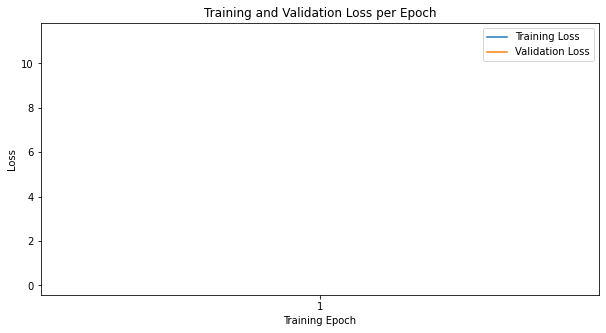

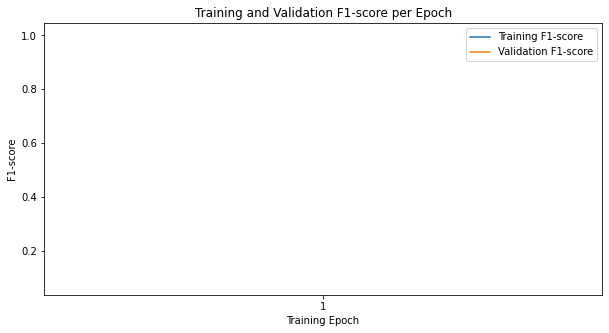

In [31]:
LEARNING_RATE = 1e-3             # learning rate of the optimiser
RNN_TYPE = 'GRU'                 # type of RNN
HIDDEN_DIM = 256                 # hidden size of RNN
NUM_LAYERS = 2                   # number of layers of RNN
WEIGHT_INIT = 'Xavier-Normal'    # weight initialization: Xavier-Normal, Xavier-Uniform, StandardNormal, Orthogonal
TRAIN_EMB = True                 # freeze or not freeze embedding layer

DROPOUT_PCT = 0                  # dropout percentage
NUM_EPOCHS = 100                 # number of epochs
WEIGHT_DECAY = 0                 # weight decay

metric = 'F1-score'              # or 'Accuracy'

train_dataset_PT_small = ([next(iter(train_dataset_PT)) for i in range(10*batchSize)]) # only use 10 batches
train_dataloader_small = DataLoader(train_dataset_PT_small, batch_size=batchSize, collate_fn=collate_batch, shuffle=True)

torch.manual_seed(42)            # Seeding PyTorch

############################################################

model = RNN(RNN_TYPE, HIDDEN_DIM, NUM_LAYERS, WEIGHT_INIT, DROPOUT_PCT, TRAIN_EMB)
print(f"Model to be trained:\n{model}\n")

device = torch.device("cuda")
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
train_losses, val_losses = [], []
train_metrics, val_metrics = [], []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    train_loss, train_metric = train_loop(train_dataloader_small, model, device, criterion, optimizer, metric, print_loss = True)
    val_loss, val_metric = val_loop(val_dataloader, model, device, criterion, metric)

    train_losses.append(train_loss), val_losses.append(val_loss)
    train_metrics.append(train_metric), val_metrics.append(val_metric)

    print(f"Avg Train loss = {train_loss:>8f}      Avg Validation loss = {val_loss:>8f}      //      Train {metric} = {train_metric:>8f}    Validation {metric} = {val_metric:>8f}\n")

    # Stop training when train_metric > 99%
    if train_metric > 0.99:
        break

plt_learning_curve(train_losses, val_losses, epoch + 1, 'Loss')
plt_learning_curve(train_metrics, val_metrics, epoch + 1, f"{metric}")

Hence, the model can quickly overfit to this smaller training set of only 10 batches. This is not surprising given the non-exisiting regularization and the large capacity of the model. Hence, it can also be evaluated whether the model is capable of overfitting to the entire training set.

Model to be trained:
RNN(
  (embedding): Embedding(2177, 100)
  (gru): GRU(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

Epoch 1
-------------------------------
loss: 1.407257  [    0/22354]
loss: 1.243777  [ 2560/22354]
loss: 1.175744  [ 5120/22354]
loss: 1.268649  [ 7680/22354]
loss: 1.171286  [10240/22354]
loss: 1.107123  [12800/22354]
loss: 1.095896  [15360/22354]
loss: 1.143047  [17920/22354]
loss: 1.126840  [20480/22354]
Avg Train loss = 1.209455      Avg Validation loss = 1.146461      //      Train F1-score = 0.395160    Validation F1-score = 0.446130

Epoch 2
-------------------------------
loss: 1.111195  [    0/22354]
loss: 1.024220  [ 2560/22354]
loss: 1.129234  [ 5120/22354]
loss: 1.046077  [ 7680/22354]
loss: 1.130078  [10240/22354]
loss: 1.021898  [12800/22354]
loss: 1.117686  [15360/22354]
loss: 1.094211  [17920/22354]
loss: 1.306427  [20480/22354]
Avg Train loss = 1.114068      Avg Validation

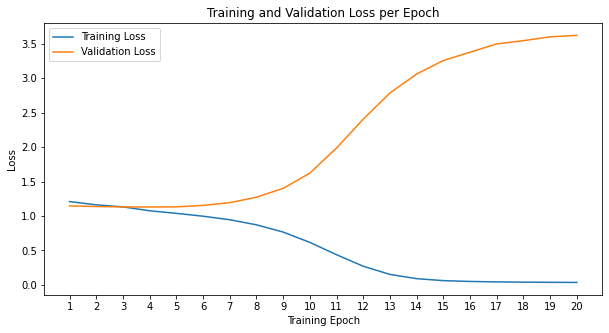

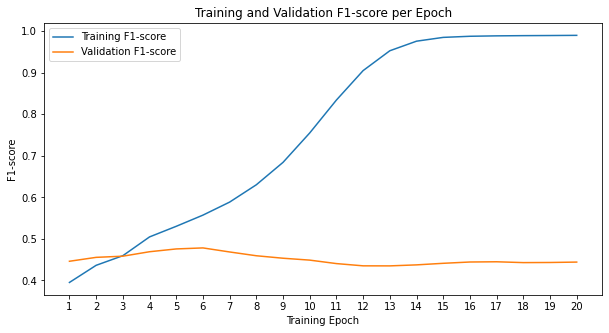

In [ ]:
LEARNING_RATE = 1e-3             # learning rate of the optimiser
RNN_TYPE = 'GRU'
HIDDEN_DIM = 256                 # hidden size of RNN
NUM_LAYERS = 2                   # number of layers of RNN
WEIGHT_INIT = 'Xavier-Normal'    # weight initialization: Xavier-Normal, Xavier-Uniform, StandardNormal, Orthogonal
TRAIN_EMB = True                 # freeze or not freeze embedding layer

DROPOUT_PCT = 0                  # dropout percentage
NUM_EPOCHS = 100                 # number of epochs
WEIGHT_DECAY = 0

metric = 'F1-score'              # metric employed (F1-score or Accuracy)

torch.manual_seed(42)            # Seeding PyTorch

############################################################

model = RNN(RNN_TYPE, HIDDEN_DIM, NUM_LAYERS, WEIGHT_INIT, DROPOUT_PCT, TRAIN_EMB)
print(f"Model to be trained:\n{model}\n")

device = torch.device("cuda")
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
train_losses, val_losses = [], []
train_metrics, val_metrics = [], []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    train_loss, train_metric = train_loop(train_dataloader, model, device, criterion, optimizer, metric, print_loss = True)
    val_loss, val_metric = val_loop(val_dataloader, model, device, criterion, metric)

    train_losses.append(train_loss), val_losses.append(val_loss)
    train_metrics.append(train_metric), val_metrics.append(val_metric)

    print(f"Avg Train loss = {train_loss:>8f}      Avg Validation loss = {val_loss:>8f}      //      Train {metric} = {train_metric:>8f}    Validation {metric} = {val_metric:>8f}\n")

    # Stop training when train_metric > 99%
    if train_metric > 0.99:
        break

plt_learning_curve(train_losses, val_losses, epoch + 1, 'Loss')
plt_learning_curve(train_metrics, val_metrics, epoch + 1, f"{metric}")

With some more epochs of training, the model is also overfitting very well to the entire training dataset, although it does not improve much at the very end and would probably struggle to reach an F1-score of 100%. However, it still shows that this model architecture is good enough to continue with.

#### Step 2: Learning rate

Next, the effect of the learning rate is evaluated by finding the one that makes the loss go down using all training data and a small regularization.


--------------------------------------
Learning rate = 0.1

Epoch 1
-------------------------------
loss: 1.403630  [    0/22354]
loss: 5.115440  [ 2560/22354]
loss: 2.807047  [ 5120/22354]
loss: 2.015569  [ 7680/22354]
loss: 3.352713  [10240/22354]
loss: 2.229251  [12800/22354]
loss: 3.508511  [15360/22354]
loss: 1.662637  [17920/22354]
loss: 2.382185  [20480/22354]
Avg Train loss = 3.286462      Avg Validation loss = 1.991453

Epoch 2
-------------------------------
loss: 2.109282  [    0/22354]
loss: 3.144326  [ 2560/22354]
loss: 3.766602  [ 5120/22354]
loss: 1.778083  [ 7680/22354]
loss: 3.859025  [10240/22354]
loss: 2.416170  [12800/22354]
loss: 2.017038  [15360/22354]
loss: 2.444114  [17920/22354]
loss: 1.543027  [20480/22354]
Avg Train loss = 2.433867      Avg Validation loss = 1.933674

Epoch 3
-------------------------------
loss: 1.978905  [    0/22354]
loss: 3.086584  [ 2560/22354]
loss: 1.878012  [ 5120/22354]
loss: 3.600145  [ 7680/22354]
loss: 6.933334  [10240/22354]
los

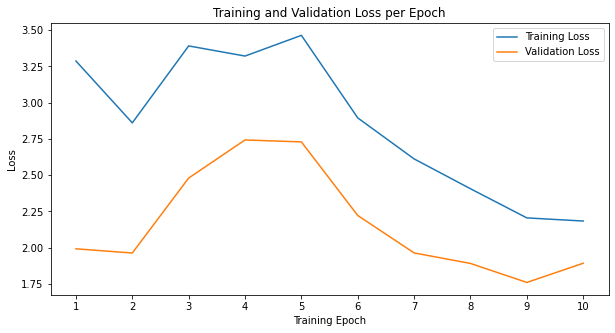


--------------------------------------
Learning rate = 0.01

Epoch 1
-------------------------------
loss: 1.424736  [    0/22354]
loss: 1.354063  [ 2560/22354]
loss: 1.205059  [ 5120/22354]
loss: 1.353006  [ 7680/22354]
loss: 1.254682  [10240/22354]
loss: 1.200345  [12800/22354]
loss: 1.188541  [15360/22354]
loss: 1.230073  [17920/22354]
loss: 1.172794  [20480/22354]
Avg Train loss = 1.400515      Avg Validation loss = 1.170397

Epoch 2
-------------------------------
loss: 1.167353  [    0/22354]
loss: 1.150259  [ 2560/22354]
loss: 1.110060  [ 5120/22354]
loss: 1.113323  [ 7680/22354]
loss: 1.207330  [10240/22354]
loss: 1.174994  [12800/22354]
loss: 1.075620  [15360/22354]
loss: 1.113668  [17920/22354]
loss: 1.175802  [20480/22354]
Avg Train loss = 1.160386      Avg Validation loss = 1.197527

Epoch 3
-------------------------------
loss: 1.131637  [    0/22354]
loss: 1.117767  [ 2560/22354]
loss: 1.053212  [ 5120/22354]
loss: 1.077346  [ 7680/22354]
loss: 1.087440  [10240/22354]
lo

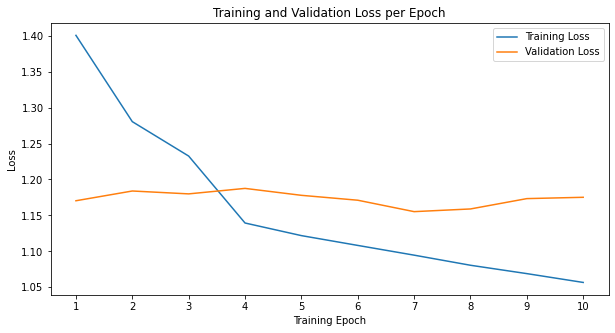


--------------------------------------
Learning rate = 0.001

Epoch 1
-------------------------------
loss: 1.409455  [    0/22354]
loss: 1.239968  [ 2560/22354]
loss: 1.183605  [ 5120/22354]
loss: 1.181858  [ 7680/22354]
loss: 1.256717  [10240/22354]
loss: 1.223729  [12800/22354]
loss: 1.120941  [15360/22354]
loss: 1.106427  [17920/22354]
loss: 1.109549  [20480/22354]
Avg Train loss = 1.219920      Avg Validation loss = 1.167033

Epoch 2
-------------------------------
loss: 1.132936  [    0/22354]
loss: 1.125260  [ 2560/22354]
loss: 1.019752  [ 5120/22354]
loss: 1.102082  [ 7680/22354]
loss: 1.184529  [10240/22354]
loss: 1.114103  [12800/22354]
loss: 1.136866  [15360/22354]
loss: 1.060692  [17920/22354]
loss: 1.049911  [20480/22354]
Avg Train loss = 1.127740      Avg Validation loss = 1.151930

Epoch 3
-------------------------------
loss: 1.124338  [    0/22354]
loss: 1.119074  [ 2560/22354]
loss: 1.071791  [ 5120/22354]
loss: 1.123239  [ 7680/22354]
loss: 1.033459  [10240/22354]
l

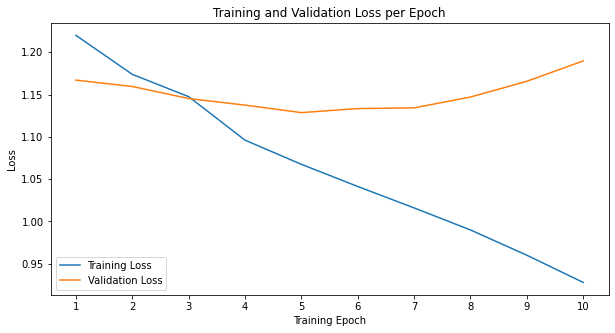


--------------------------------------
Learning rate = 0.0001

Epoch 1
-------------------------------
loss: 1.371777  [    0/22354]
loss: 1.346877  [ 2560/22354]
loss: 1.303298  [ 5120/22354]
loss: 1.267079  [ 7680/22354]
loss: 1.247442  [10240/22354]
loss: 1.235125  [12800/22354]
loss: 1.265198  [15360/22354]
loss: 1.252986  [17920/22354]
loss: 1.178798  [20480/22354]
Avg Train loss = 1.275906      Avg Validation loss = 1.228214

Epoch 2
-------------------------------
loss: 1.277179  [    0/22354]
loss: 1.223386  [ 2560/22354]
loss: 1.270794  [ 5120/22354]
loss: 1.256062  [ 7680/22354]
loss: 1.132657  [10240/22354]
loss: 1.183213  [12800/22354]
loss: 1.204553  [15360/22354]
loss: 1.094490  [17920/22354]
loss: 1.110006  [20480/22354]
Avg Train loss = 1.188593      Avg Validation loss = 1.186788

Epoch 3
-------------------------------
loss: 1.233474  [    0/22354]
loss: 1.209233  [ 2560/22354]
loss: 1.154336  [ 5120/22354]
loss: 1.219520  [ 7680/22354]
loss: 1.136256  [10240/22354]


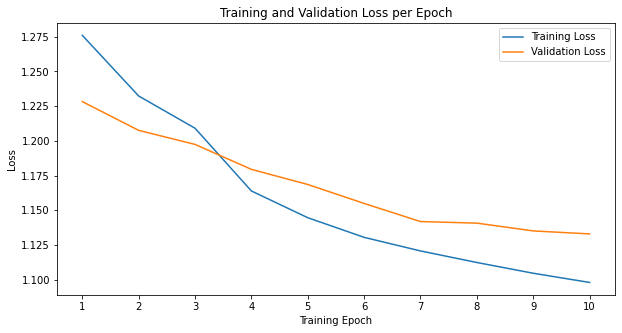

In [ ]:
HIDDEN_DIM = 256                  
NUM_LAYERS = 2                    
WEIGHT_INIT = 'Xavier-Normal'    
RNN_TYPE = 'GRU'
TRAIN_EMB = True                 
DROPOUT_PCT = 0.1                
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10                  

metric = 'F1-score'

torch.manual_seed(42)            

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

for LEARNING_RATE in learning_rates:
  print(f"\n--------------------------------------\nLearning rate = {LEARNING_RATE}\n")

  model = RNN(RNN_TYPE, HIDDEN_DIM, NUM_LAYERS, WEIGHT_INIT, DROPOUT_PCT, TRAIN_EMB)

  device = torch.device("cuda")
  model = model.to(device)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
  train_losses, val_losses = [], []

  for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    train_loss, _ = train_loop(train_dataloader, model, device, criterion, optimizer, metric, print_loss = True)
    val_loss, _ = val_loop(val_dataloader, model, device, criterion, metric)
    train_losses.append(train_loss), val_losses.append(val_loss)

    print(f"Avg Train loss = {train_loss:>8f}      Avg Validation loss = {val_loss:>8f}\n")

  plt_learning_curve(train_losses, val_losses, epoch + 1, 'Loss')

From the experimentation with different learning rates, it can be seen that `LEARNING_RATE = 0.0001` worked best for this low number of epochs. There, the validation loss dropped the fastest and, in fact, behaved similar to the training loss.


#### Step 3: Coarse grid search

Next, grid search on the learning rate, dropout percentage and weight decay with a low number of training epochs is employed.

In [ ]:
HIDDEN_DIM = 256                  
NUM_LAYERS = 2                    
RNN_TYPE = 'GRU'
WEIGHT_INIT = 'Xavier-Normal'     
TRAIN_EMB = True                  
NUM_EPOCHS = 5                   

metric = 'F1-score'              

torch.manual_seed(42)             

learning_rates = [0.00005, 0.0001, 0.0002]
dropout_pcts = [0.1, 0.3, 0.5]
weight_decays = [1e-4, 1e-5, 0]


for LEARNING_RATE in learning_rates:
  for DROPOUT_PCT in dropout_pcts:
    for WEIGHT_DECAY in weight_decays:
      print(f"\n--------------------------------------\nLearning rate = {LEARNING_RATE}     Dropout percentage = {DROPOUT_PCT}     Weight Decay = {WEIGHT_DECAY}\n")

      model = RNN(RNN_TYPE, HIDDEN_DIM, NUM_LAYERS, WEIGHT_INIT, DROPOUT_PCT, TRAIN_EMB)

      device = torch.device("cuda")
      model = model.to(device)
      criterion = torch.nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)

      for epoch in range(NUM_EPOCHS):
        train_loss, train_metric = train_loop(train_dataloader, model, device, criterion, optimizer, metric, print_loss = False)
        val_loss, val_metric = val_loop(val_dataloader, model, device, criterion, metric)

      print(f"Epoch {epoch+1}:   Avg Train loss = {train_loss:>8f}      Avg Validation loss = {val_loss:>8f}  //      Train {metric} = {train_metric:>8f}    Validation {metric} = {val_metric:>8f}\n")


--------------------------------------
Learning rate = 5e-05     Dropout percentage = 0.1     Weight Decay = 0.0001

Epoch 5:   Avg Train loss = 1.176538      Avg Validation loss = 1.161693  //      Train F1-score = 0.401883    Validation F1-score = 0.403324


--------------------------------------
Learning rate = 5e-05     Dropout percentage = 0.1     Weight Decay = 1e-05

Epoch 5:   Avg Train loss = 1.167965      Avg Validation loss = 1.167268  //      Train F1-score = 0.406757    Validation F1-score = 0.419043


--------------------------------------
Learning rate = 5e-05     Dropout percentage = 0.1     Weight Decay = 0

Epoch 5:   Avg Train loss = 1.167747      Avg Validation loss = 1.163915  //      Train F1-score = 0.404145    Validation F1-score = 0.400169


--------------------------------------
Learning rate = 5e-05     Dropout percentage = 0.3     Weight Decay = 0.0001

Epoch 5:   Avg Train loss = 1.174416      Avg Validation loss = 1.169428  //      Train F1-score = 0.3993

Here, the best performance with regard to the validation loss was achieved using Learning rate = 0.0002, Dropout percentage = 0.1 and Weight Decay = 0.
Therefore, these values are used as a starting point for a finer random search in the neighborhood of these values.

#### Step 4: Finer random search


--------------------------------------
Learning rate = 0.00020712016202770363     Dropout percentage = 0.11261628338589158     Weight Decay = 2.5222635490677235e-05

Avg Train loss = 1.035385      Avg Validation loss = 1.146229      //      Train F1-score = 0.531762    Validation F1-score = 0.459447



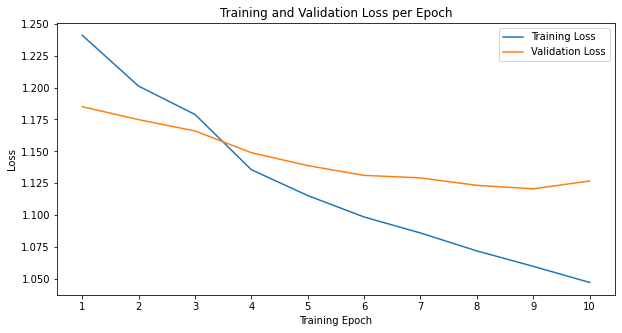

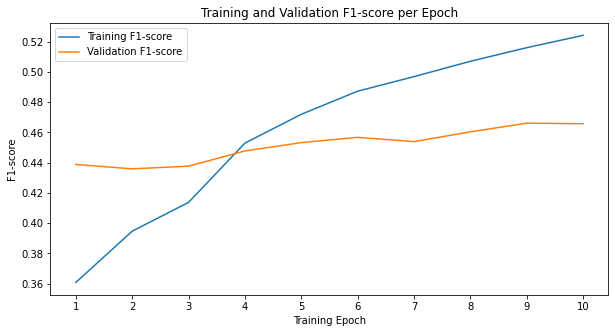


--------------------------------------
Learning rate = 0.0002832858138105114     Dropout percentage = 0.29380993636260366     Weight Decay = 0.0007952095742397425

Avg Train loss = 1.094271      Avg Validation loss = 1.142458      //      Train F1-score = 0.485458    Validation F1-score = 0.472169



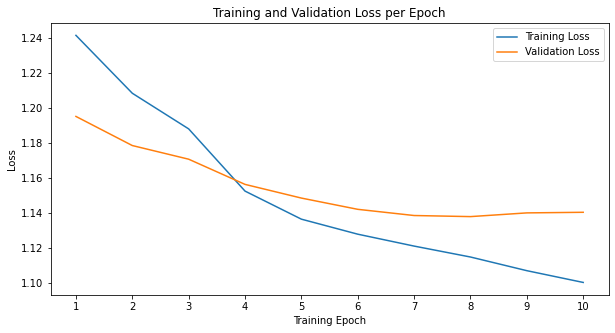

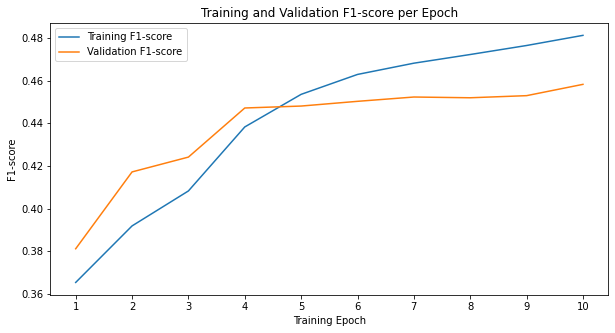


--------------------------------------
Learning rate = 0.00013363378665117709     Dropout percentage = 0.13893892768769575     Weight Decay = 0.0005377732256532498

Avg Train loss = 1.102828      Avg Validation loss = 1.132088      //      Train F1-score = 0.481762    Validation F1-score = 0.455838



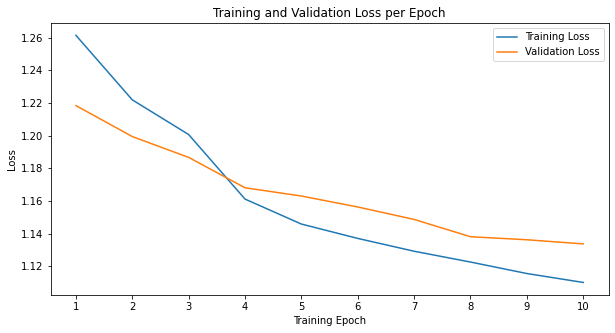

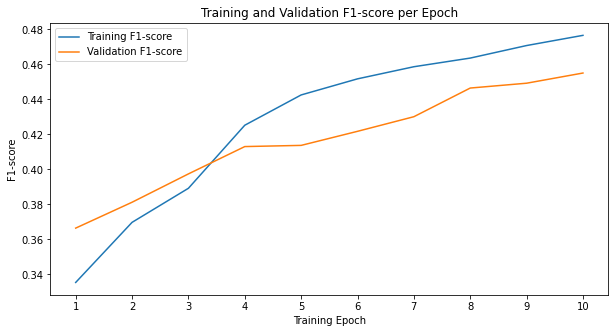


--------------------------------------
Learning rate = 0.00029986772236811736     Dropout percentage = 0.24555481170667093     Weight Decay = 0.00048329544243919066

Avg Train loss = 1.074506      Avg Validation loss = 1.130706      //      Train F1-score = 0.505179    Validation F1-score = 0.471878



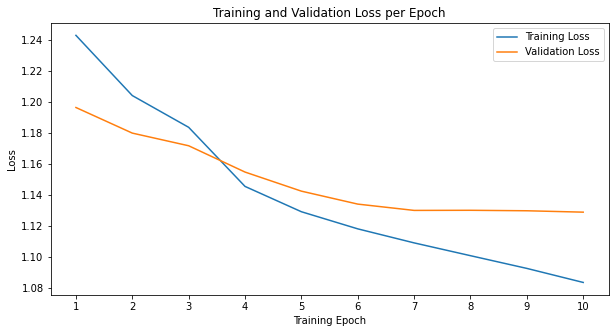

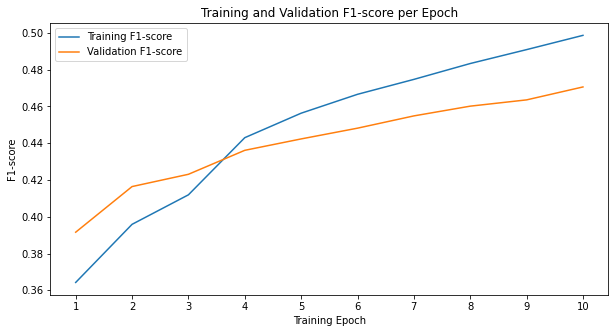


--------------------------------------
Learning rate = 0.00014304653873769367     Dropout percentage = 0.0032468001021437208     Weight Decay = 0.0009166982700775819

Avg Train loss = 1.113163      Avg Validation loss = 1.146761      //      Train F1-score = 0.473448    Validation F1-score = 0.446753



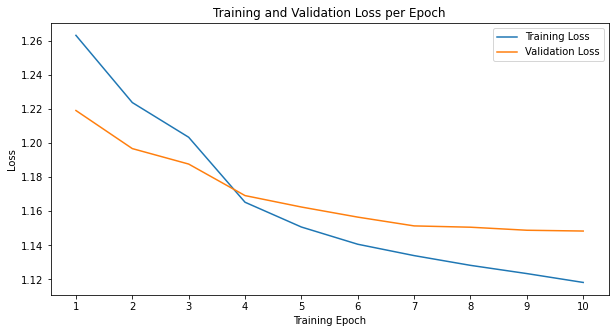

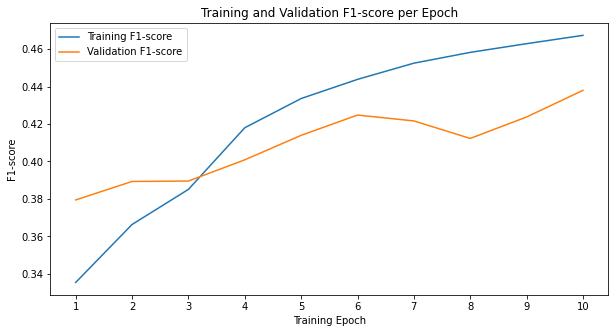


--------------------------------------
Learning rate = 0.0002900407506857579     Dropout percentage = 0.08982064596245162     Weight Decay = 0.00021544257945689868

Avg Train loss = 1.053549      Avg Validation loss = 1.128049      //      Train F1-score = 0.521086    Validation F1-score = 0.460247



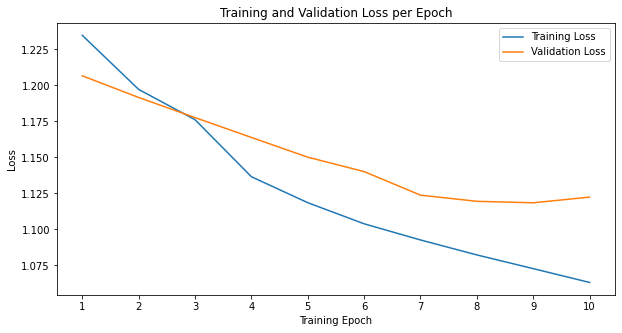

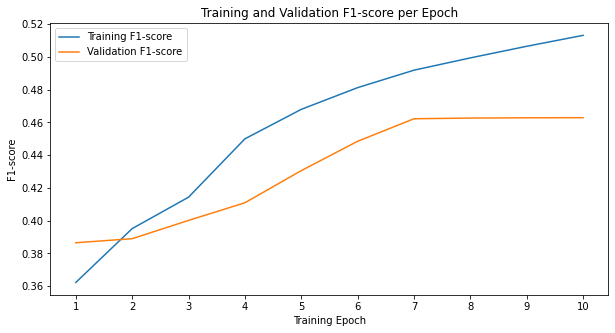


--------------------------------------
Learning rate = 0.00012660321582747797     Dropout percentage = 0.16705085885864418     Weight Decay = 0.0006453307109964682

Avg Train loss = 1.110062      Avg Validation loss = 1.146811      //      Train F1-score = 0.475356    Validation F1-score = 0.448901



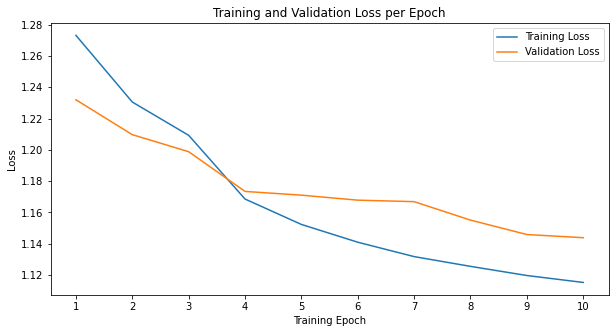

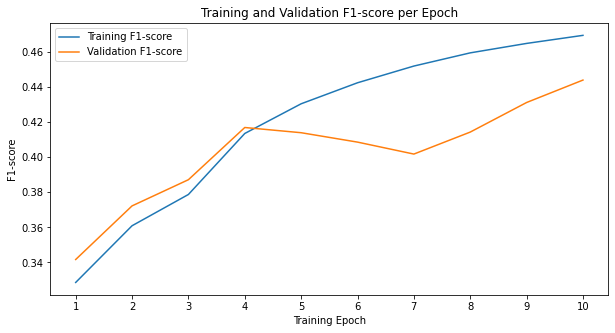


--------------------------------------
Learning rate = 0.00022177621638871838     Dropout percentage = 0.2376872758814486     Weight Decay = 0.00084485993872253

Avg Train loss = 1.101266      Avg Validation loss = 1.138121      //      Train F1-score = 0.478263    Validation F1-score = 0.442729



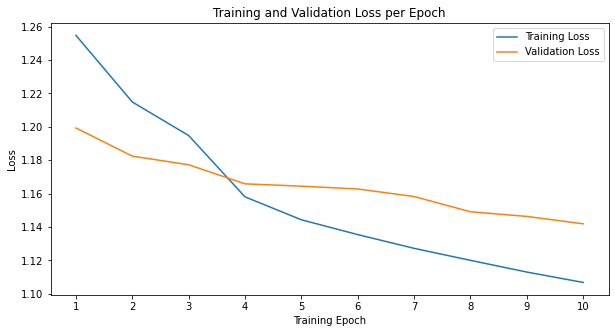

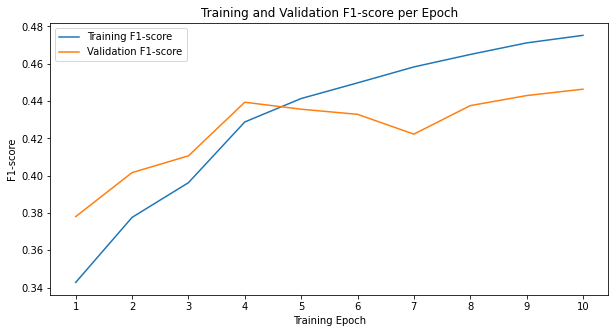


--------------------------------------
Learning rate = 0.0001333589901724388     Dropout percentage = 0.15338620354779814     Weight Decay = 7.691992787970067e-05

Avg Train loss = 1.075357      Avg Validation loss = 1.129755      //      Train F1-score = 0.502586    Validation F1-score = 0.460844



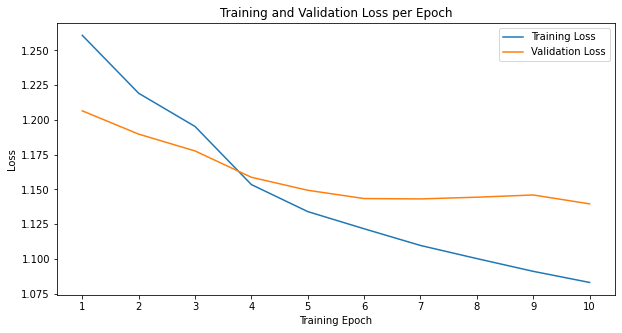

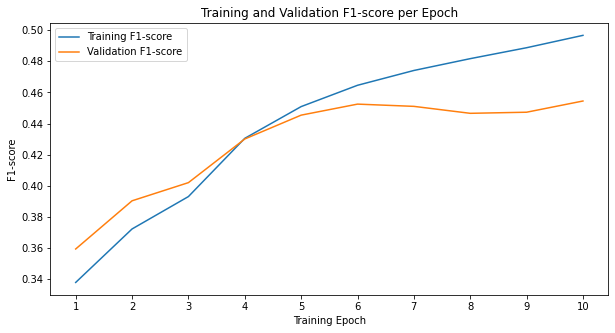


--------------------------------------
Learning rate = 0.00015042120765108462     Dropout percentage = 0.07465563083202069     Weight Decay = 0.00016306750654304747

Avg Train loss = 1.079819      Avg Validation loss = 1.119423      //      Train F1-score = 0.503454    Validation F1-score = 0.474744



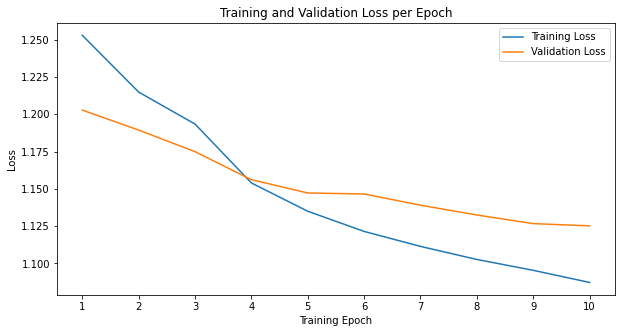

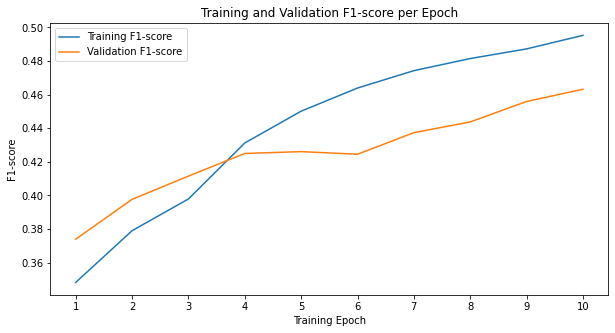

In [ ]:
# best parameters from step 3: Learning rate = 0.0002     Dropout percentage = 0     Weight Decay = 0

n_random_searches = 10

HIDDEN_DIM = 256                  
NUM_LAYERS = 2                   
WEIGHT_INIT = 'Xavier-Normal'    
RNN_TYPE = 'GRU'
TRAIN_EMB = True                 
NUM_EPOCHS = 10                  

metric = 'F1-score' 

torch.manual_seed(42)  

for n in range(n_random_searches):

  LEARNING_RATE = random.uniform(0.0001, 0.0003)
  DROPOUT_PCT = random.uniform(0.0, 0.3)
  WEIGHT_DECAY = random.uniform(1e-06, 1e-3)

  print(f"\n--------------------------------------\nLearning rate = {LEARNING_RATE}     Dropout percentage = {DROPOUT_PCT}     Weight Decay = {WEIGHT_DECAY}\n")

  model = RNN(RNN_TYPE, HIDDEN_DIM, NUM_LAYERS, WEIGHT_INIT, DROPOUT_PCT, TRAIN_EMB)

  device = torch.device("cuda")
  model = model.to(device)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
  train_losses, val_losses = [], []
  train_metrics, val_metrics = [], []

  for epoch in range(NUM_EPOCHS):
    train_loss, train_metric = train_loop(train_dataloader, model, device, criterion, optimizer, metric, print_loss = False)
    val_loss, val_metric = val_loop(val_dataloader, model, device, criterion, metric)
    train_losses.append(train_loss), val_losses.append(val_loss)
    train_metrics.append(train_metric), val_metrics.append(val_metric)


  print(f"Avg Train loss = {train_loss:>8f}      Avg Validation loss = {val_loss:>8f}      //      Train {metric} = {train_metric:>8f}    Validation {metric} = {val_metric:>8f}\n")
  plt_learning_curve(train_losses, val_losses, epoch + 1, 'Loss')
  plt_learning_curve(train_metrics, val_metrics, epoch + 1, f"{metric}")

Finetuning these three parameter values, Learning rate = 0.00015042120765108462, Dropout percentage = 0.07465563083202069 and Weight Decay = 0.00016306750654304747 resulted in the lowest validation loss and are therefore used for the subsequent step 5. Also, the learning curve suggests that training has not finished yet and suggests training the model longer.

#### Step 5: Train tuned model for longer

Epoch 1
-------------------------------
loss: 1.408042  [    0/22354]
loss: 1.304807  [ 2560/22354]
loss: 1.243542  [ 5120/22354]
loss: 1.316982  [ 7680/22354]
loss: 1.330545  [10240/22354]
loss: 1.232486  [12800/22354]
loss: 1.169535  [15360/22354]
loss: 1.162174  [17920/22354]
loss: 1.194488  [20480/22354]
Avg Train loss = 1.255961      Avg Validation loss = 1.205739      //      Train F1-score = 0.350908    Validation F1-score = 0.406141

Epoch 2
-------------------------------
loss: 1.198109  [    0/22354]
loss: 1.090605  [ 2560/22354]
loss: 1.147129  [ 5120/22354]
loss: 1.163236  [ 7680/22354]
loss: 1.221267  [10240/22354]
loss: 1.119412  [12800/22354]
loss: 1.193433  [15360/22354]
loss: 1.160472  [17920/22354]
loss: 1.297831  [20480/22354]
Avg Train loss = 1.173706      Avg Validation loss = 1.179135      //      Train F1-score = 0.412646    Validation F1-score = 0.426787

Epoch 3
-------------------------------
loss: 1.130208  [    0/22354]
loss: 1.211235  [ 2560/22354]
loss: 1.

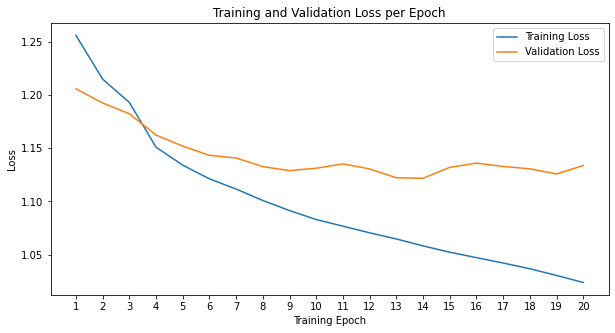

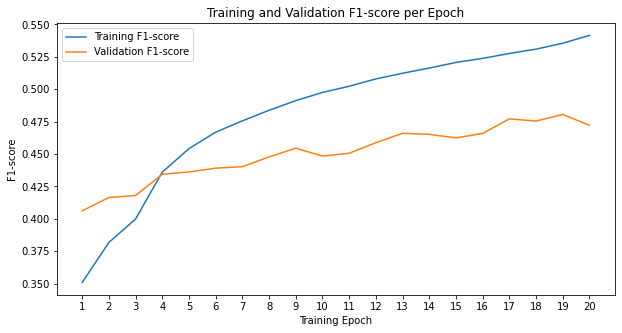

In [ ]:
LEARNING_RATE = 0.00015042120765108462
DROPOUT_PCT = 0.07465563083202069 
WEIGHT_DECAY = 0.00016306750654304747

WEIGHT_INIT = 'Xavier-Normal'
HIDDEN_DIM = 256             
NUM_LAYERS = 2        
RNN_TYPE = 'GRU'
TRAIN_EMB = True      
NUM_EPOCHS = 20       

metric = 'F1-score'  

torch.manual_seed(42) 

############################################################

model = RNN(RNN_TYPE, HIDDEN_DIM, NUM_LAYERS, WEIGHT_INIT, DROPOUT_PCT, TRAIN_EMB)

device = torch.device("cuda")
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
train_losses, val_losses = [], []
train_metrics, val_metrics = [], []

for epoch in range(NUM_EPOCHS):
  print(f"Epoch {epoch + 1}\n-------------------------------")

  train_loss, train_metric = train_loop(train_dataloader, model, device, criterion, optimizer, metric, print_loss = True)
  val_loss, val_metric = val_loop(val_dataloader, model, device, criterion, metric)

  train_losses.append(train_loss), val_losses.append(val_loss)
  train_metrics.append(train_metric), val_metrics.append(val_metric)

  print(f"Avg Train loss = {train_loss:>8f}      Avg Validation loss = {val_loss:>8f}      //      Train {metric} = {train_metric:>8f}    Validation {metric} = {val_metric:>8f}\n")

plt_learning_curve(train_losses, val_losses, epoch + 1, 'Loss')
plt_learning_curve(train_metrics, val_metrics, epoch + 1, f"{metric}")

Training the model for longer with a constant learning rate and analyzing the learning curve of moving averages, it can be seen that the training went reasonably well and overfitting barely took place. Also, the learning got slower towards the end which proposes the idea to use learning rate decay once such a loss plateaus is reached. This might even improve the model when training it accordingly for more epochs and just stop the training when either the training loss does not significantly decrease or the validation loss increases over two consecutive epochs. This is implemented in step 6.

#### Step 6: Train final model

As explained before, the final model is trained. Here, to avoid the case that one is left with an overfitted model at the very end, the best model state is always stored for the model with the lowest validation accuracy over the past 5 epochs. Also, the training rate is decreased three times before the training can be finished.

Model to be trained:
RNN(
  (embedding): Embedding(2177, 100)
  (gru): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.07465563083202069, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)


Epoch 1
-------------------------------
loss: 1.407468  [    0/22354]
loss: 1.303293  [ 2560/22354]
loss: 1.245749  [ 5120/22354]
loss: 1.320224  [ 7680/22354]
loss: 1.325729  [10240/22354]
loss: 1.230282  [12800/22354]
loss: 1.167719  [15360/22354]
loss: 1.168146  [17920/22354]
loss: 1.193905  [20480/22354]
Avg Train loss = 1.255591      Avg Validation loss = 1.206538      //      Train F1-score = 0.349048    Validation F1-score = 0.404287
Model saved

Epoch 2
-------------------------------
loss: 1.200831  [    0/22354]
loss: 1.089302  [ 2560/22354]
loss: 1.147349  [ 5120/22354]
loss: 1.156561  [ 7680/22354]
loss: 1.219118  [10240/22354]
loss: 1.118523  [12800/22354]
loss: 1.193889  [15360/22354]
loss: 1.162250  [17920/22354]
loss: 1.294799  [20480/22354]
Avg

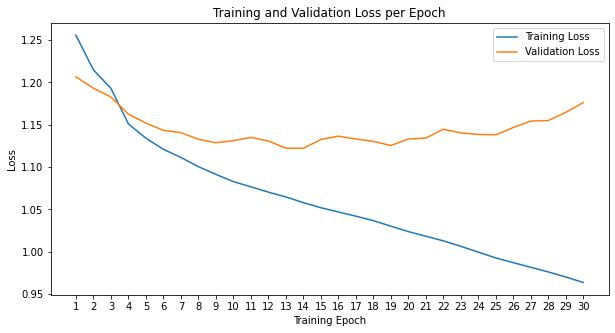

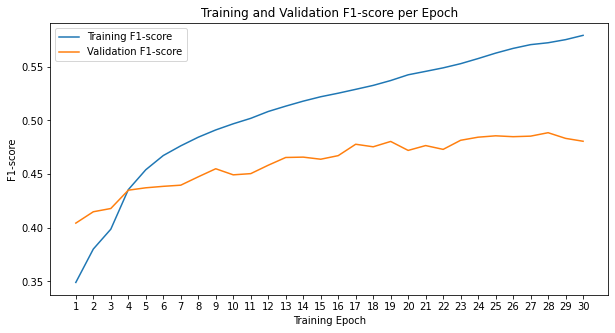

In [ ]:
LEARNING_RATE = 0.00015042120765108462
DROPOUT_PCT = 0.07465563083202069 
WEIGHT_DECAY = 0.00016306750654304747

HIDDEN_DIM = 256
NUM_LAYERS = 2
WEIGHT_INIT = 'Xavier-Normal' 

RNN_TYPE = 'GRU'
TRAIN_EMB = True
NUM_EPOCHS = 100

metric = 'F1-score'
LR_DECAY = 0

torch.manual_seed(42)

############################################################

model = RNN(RNN_TYPE, HIDDEN_DIM, NUM_LAYERS, WEIGHT_INIT, DROPOUT_PCT, TRAIN_EMB)
print(f"Model to be trained:\n{model}\n")

device = torch.device("cuda")
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
train_losses, val_losses = [], []
train_metrics, val_metrics = [], []

for epoch in range(NUM_EPOCHS):
  print(f"\nEpoch {epoch + 1}\n-------------------------------")
  train_loss, train_metric = train_loop(train_dataloader, model, device, criterion, optimizer, metric, print_loss = True)
  val_loss, val_metric = val_loop(val_dataloader, model, device, criterion, metric)
  train_losses.append(train_loss), val_losses.append(val_loss)
  train_metrics.append(train_metric), val_metrics.append(val_metric)

  print(f"Avg Train loss = {train_loss:>8f}      Avg Validation loss = {val_loss:>8f}      //      Train {metric} = {train_metric:>8f}    Validation {metric} = {val_metric:>8f}")


  if val_losses[-1] == min(val_losses[-5:]):
    print('Model saved')
    best_model_state =  model.state_dict()


  # Stop training when the training loss does not improve for two consecutive epochs or the validation loss increases two times in a row
  if epoch > 4:
    if (train_losses[-2] - train_losses[-1] < 0.0001) or ((val_losses[-1] > val_losses[-2]) and (val_losses[-2] > val_losses[-3])):
      if LR_DECAY == 3:
        break

      LEARNING_RATE /= 2
      LR_DECAY += 1
      print('Adjustment of learning has taken place.')


plt_learning_curve(train_losses, val_losses, epoch + 1, 'Loss')
plt_learning_curve(train_metrics, val_metrics, epoch + 1, f"{metric}")

It can be seen that the model is overfitting towards the end of the training, however, the best model state was already saved in epoch 24 because there, the lowest validation loss was reached and therefore, this overfitting does not affect this tuned model.

## Save model

Since the tuning of the model with its hyperparameters is completed now, the state of the model is saved such that it can easily be reloaded.

In [ ]:
torch.save(best_model_state, data_dir+'tuned_model.pth')

In addition, to speed up the evaluation process, the vocabulary and embedding matrix are saved.

In [ ]:
torch.save(vocab, data_dir+'vocab.pth')
torch.save(embedding_matrix, data_dir+'embedding_matrix.pth')

# Evaluate tuned model 
(**for evaluation purposes, start at this section**)

**Note:** When uploading the vocab and the embedding matrix to ILIAS, this changed their data types from *vocab.pth* to *vocabpth.sec*. When I tried to load and use them, it still worked, however, when it does not work for you, please either write me an email such that I can send you the *.pth* files or execute the code block ***Alternative preparation*** below which manually constructs the vocab and embedding matrix again (run time roughly 12 minutes) and then return to ***Evaluation***.

## Preparation

**Please modify the `data_dir` path according to your directory structure**

In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torchtext.vocab import vocab
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# mount drive
from google.colab import drive
drive.mount('/content/drive')

class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
      self.data = data

    def __len__(self):
      return(self.data.shape[0])

    def __getitem__(self, idx):
      return (self.data.iloc[idx,0], self.data.iloc[idx,1])

codes = {'sadness': 0,  
         'worry' : 1,
         'neutral': 2,
         'happiness': 3}

def collate_batch(batch):
  text_list = []
  labels = torch.zeros((len(batch), 4))
  lengths = torch.zeros((len(batch)))
  for i, (label, text) in enumerate(batch):
    label_text = codes[label]
    labels[i, label_text] = 1

    processed_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64)
    text_list.append(processed_text)
    lengths[i] = len(processed_text)

  text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab(['<pad>'])[0])
  return text_list, labels, lengths

tokenizer = get_tokenizer('basic_english')

class RNN(nn.Module):
  def __init__(self, rnn_type, hidden_dim, num_layers, weight_init, dropout_pct, train_emb):
    super().__init__()

    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = not train_emb)
    self.rnn_type = rnn_type
    if rnn_type == 'LSTM':
      self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers = num_layers, dropout = dropout_pct, bidirectional = True, batch_first = True)
    elif rnn_type == 'GRU':
      self.gru = nn.GRU(embedding_matrix.shape[1], hidden_dim, num_layers = num_layers, dropout = dropout_pct, bidirectional = True, batch_first = True)

    self.fc = nn.Linear(hidden_dim*2, 4)

    self.weight_init = weight_init
    def _weights_init(m):
        if isinstance(m, nn.Linear or nn.GRU or nn.LSTM):
          if self.weight_init == 'Xavier-Normal':
            nn.init.xavier_normal_(m.weight)
          elif self.weight_init == 'Xavier-Uniform':
            nn.init.xavier_uniform_(m.weight)
          elif self.weight_init == 'StandardNormal':
            nn.init.xavier_normal_(m.weight)
          elif self.weight_init == 'Orthogonal':
            nn.init.orthogonal_(m.weight)
          else:      
            raise ValueError('Please enter a valid weight initialization method (one of: Xavier-Normal, Xavier-Uniform, StandardNormal, Orthogonal).')
          m.bias.data.zero_()
    self.apply(_weights_init) 


  def forward(self, text, lengths):
    embedded = self.embedding(text)
    embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first = True, enforce_sorted = False)

    if self.rnn_type == 'LSTM':
      output, (hidden, cell) = self.lstm(embedded)
    elif self.rnn_type == 'GRU':
      output, hidden = self.gru(embedded)
    else:
      raise ValueError('Please enter a valid RNN Type (one of LSTM, GRU).')

    model_output = self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    return  model_output

data_dir = "/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_2/" ### to be adjusted

vocab = torch.load(data_dir+'vocabpth.sec')
embedding_matrix = torch.load(data_dir+'embedding_matrixpth.sec')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Evaluation

In [4]:
# Define function for evaluating model on blind test set

def evaluate_model(path_data):
  # instantiate model
  DROPOUT_PCT = 0.10541038373315123 
  HIDDEN_DIM = 256                 
  NUM_LAYERS = 2                    
  WEIGHT_INIT = 'Xavier-Normal'     
  RNN_TYPE = 'GRU'
  TRAIN_EMB = True                  
  model_loaded = RNN(RNN_TYPE, HIDDEN_DIM, NUM_LAYERS, WEIGHT_INIT, DROPOUT_PCT, TRAIN_EMB).to(device)
  model_loaded.load_state_dict(torch.load(data_dir+'tuned_modelpth.sec')) # load weights of tuned model

  data_test_df = pd.read_csv(path_data)
  data_test_PT = Custom_Dataset(data_test_df)
  test_dataloader = DataLoader(data_test_PT, batch_size=128, collate_fn=collate_batch, shuffle=True)

  y_preds, y_true = [], []
  num_batches = len(test_dataloader)
  model_loaded.eval()
  with torch.no_grad():
    for (text, labels, lengths) in test_dataloader:
      outputs = model_loaded(text.to(device), lengths).squeeze(1)  

      y_preds.append(torch.argmax(outputs, dim=1))
      y_true.append(torch.argmax(labels, dim=1))
    
  y_preds = torch.cat(y_preds).cpu().detach().numpy()
  y_true = torch.cat(y_true).cpu().detach().numpy()

  return print(f"Macro F1-Score on blind test set: {f1_score(y_true, y_preds, average='macro')}")

In [5]:
PATH_DATA = '/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_2/training.csv' ## please specify the path to the unknown test set
device = 'cuda'

evaluate_model(PATH_DATA)

Macro F1-Score on blind test set: 0.5799080402106148


## Alternative preparation [*can be ignored when the import of vocab and embedding matrix works*]
**Approximate run time: 12 minutes (mainly due to loading of GloVe embeddings and vocab construction)** <br />
Note: then, also `training.csv` is needed

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torchtext.vocab import vocab
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

data_dir = "/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_2/" ### to be adjusted

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load data and create training and validation datasets

In [ ]:
data = pd.read_csv(data_dir+'training.csv')  
n_classes = len(data['sentiment'].unique())

print(f"Shape of dataset: {data.shape}")
print(f"Labels of training dataset: {data['sentiment'].unique()}")
display(data.head())

Shape of dataset: (24837, 2)
Labels of training dataset: ['sadness' 'neutral' 'worry' 'happiness']


,sentiment,content
0,sadness,Layin n bed with a headache ughhhh...waitin o...
1,sadness,Funeral ceremony...gloomy friday...
2,neutral,@dannycastillo We want to trade with someone w...
3,worry,Re-pinging @ghostridah14: why didn't you go to...
4,sadness,"I should be sleep, but im not! thinking about ..."


In [ ]:
np.random.seed(42)

train_dataset = data.sample(int(np.ceil(0.9*data.shape[0])), replace = False)
val_dataset = data.drop(train_dataset.index)

print(f"Shape of training dataset: {train_dataset.shape}")
print(f"Shape of validation dataset: {val_dataset.shape}")

Shape of training dataset: (22354, 2)
Shape of validation dataset: (2483, 2)


### Implement a custom PyTorch `Dataset` class

In [ ]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
      self.data = data

    def __len__(self):
      return(self.data.shape[0])

    def __getitem__(self, idx):
      return (self.data.iloc[idx,0], self.data.iloc[idx,1])

train_dataset_PT = Custom_Dataset(train_dataset)
val_dataset_PT = Custom_Dataset(val_dataset)

### Load the 100-dimensional `GloVe`embeddings pre-trained on the Twitter dataset

In [ ]:
glove = torchtext.vocab.GloVe(name='twitter.27B', dim=100, cache=data_dir)
print('Loaded {} words'.format(len(glove.itos)))

Loaded 1193514 words


### Build vocabulary

In [ ]:
def tokenize(data_iter):
  for label_class, text in data_iter:
    tokenized_text = tokenizer(text)
    text_reduced = [token for token in tokenized_text if token in glove_words] # drop tokens which are not part of GloVe vocab
    yield text_reduced

In [ ]:
tokenizer = get_tokenizer('basic_english')
glove_words = list(glove.stoi)

In [ ]:
vocab = torchtext.vocab.build_vocab_from_iterator(tokenize(train_dataset_PT), specials=["<unk>"], min_freq=10)
pad_index = 0
vocab.insert_token("<pad>", 0)
vocab.set_default_index(vocab["<unk>"])

In [ ]:
print(vocab(['here', 'is']))
print(len(vocab))

[104, 15]
2177


In [ ]:
embedding_matrix = torch.zeros((len(vocab), 100))

for i, word in enumerate(vocab.get_itos()):
  try:
    embedding_matrix[i,] = glove.vectors[glove.stoi[word]]
  except KeyError:
    print(f"Token to be randomly initialized: {word}")
    embedding_matrix[i,] = torch.randn(size=(100,))

print(embedding_matrix.shape)

Token to be randomly initialized: <pad>
Token to be randomly initialized: <unk>
torch.Size([2177, 100])


### Dataloader

In [ ]:
next(iter(train_dataset_PT))

('happiness',
 "Morning Ali a big thank you for yesterday love you always xxxx. You out on the bike today? Don't forget to get a helmet ok")

In [ ]:
codes = {'sadness': 0,  
         'worry' : 1,
         'neutral': 2,
         'happiness': 3}

In [ ]:
def collate_batch(batch):
  text_list = []
  labels = torch.zeros((len(batch), n_classes))
  lengths = torch.zeros((len(batch)))
  for i, (label, text) in enumerate(batch):
    label_text = codes[label]
    labels[i, label_text] = 1

    processed_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64)
    text_list.append(processed_text)
    lengths[i] = len(processed_text)

  text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=pad_index)
  return text_list, labels, lengths


batchSize = 128

train_dataloader = DataLoader(train_dataset_PT, batch_size=batchSize, collate_fn=collate_batch, shuffle=True)
val_dataloader = DataLoader(val_dataset_PT, batch_size=batchSize, collate_fn=collate_batch, shuffle=True)

### Recurrent Model

In [ ]:
class RNN(nn.Module):
  def __init__(self, rnn_type, hidden_dim, num_layers, weight_init, dropout_pct, train_emb):
    super().__init__()

    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = not train_emb)
    self.rnn_type = rnn_type
    if rnn_type == 'LSTM':
      self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, num_layers = num_layers, dropout = dropout_pct, bidirectional = True, batch_first = True)
    elif rnn_type == 'GRU':
      self.gru = nn.GRU(embedding_matrix.shape[1], hidden_dim, num_layers = num_layers, dropout = dropout_pct, bidirectional = True, batch_first = True)

    self.fc = nn.Linear(hidden_dim*2, n_classes)

    self.weight_init = weight_init
    def _weights_init(m):
        if isinstance(m, nn.Linear or nn.GRU or nn.LSTM):
          if self.weight_init == 'Xavier-Normal':
            nn.init.xavier_normal_(m.weight)
          elif self.weight_init == 'Xavier-Uniform':
            nn.init.xavier_uniform_(m.weight)
          elif self.weight_init == 'StandardNormal':
            nn.init.xavier_normal_(m.weight)
          elif self.weight_init == 'Orthogonal':
            nn.init.orthogonal_(m.weight)
          else:      
            raise ValueError('Please enter a valid weight initialization method (one of: Xavier-Normal, Xavier-Uniform, StandardNormal, Orthogonal).')
          m.bias.data.zero_()
    self.apply(_weights_init) 


  def forward(self, text, lengths):
    embedded = self.embedding(text)
    embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first = True, enforce_sorted = False)

    if self.rnn_type == 'LSTM':
      output, (hidden, cell) = self.lstm(embedded)
    elif self.rnn_type == 'GRU':
      output, hidden = self.gru(embedded)
    else:
      raise ValueError('Please enter a valid RNN Type (one of LSTM, GRU).')

    model_output = self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)) 
    return  model_output 